Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Overview
This notebook loads in all the simulated truncations (with model scores) as well as the experimentally tested subset of truncations. It then creates a plot showing the distribution of model scores for each tested truncation.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Experimental PD affinity estimate 

These affinity estimates are fairly small so we directly embed them below.

In [ ]:
# Tuple of form: (Seq, Stringency, Kd)

validated_core_seqs = [ ('TTTGGTGGATAGTAA', 1, '< 512 nM'),
                        ('AGAGGATTTGGTGGATAGT', 0, '> 512nM'),
                        ('AGAGGATTTGGTGGATAGTAAAT', 3, '< 32 nM'),
                        ('GAGGATTTGGTGGATAGTAAATC', 4, '< 8 nM'),
                        ('GAGGATTTGGTGGATAGTAAATCTTTG', 4, '< 8 nM'),
                        ('AAGAGGATTTGGTGGATAGTAAATCTT', 4, '< 8 nM'),
                        ('CAAGAGGATTTGGTGGATAGTAAATCTTTGC', 4, '< 8 nM'),
                        ('GATAGTAAATCTTTGCCTATCCA', 0, '> 512nM'),
                        ('GTGGATAGTAAATCTTTGCCTATCCAG', 0, '> 512nM'),
                        ('TTTGGTGGATAGTAAATCTTTGC', 0, '> 512nM'),
                        ('CAAGAGGATTTGGTGGATAGTAAATCTTTGCCTAT', 3, '< 32 nM'),
                        ('CAAGAGGATTTGGTGGATAGTAAATCTTTGCCTATCCAG', 3, '< 32 nM'),
                        ('GTTTTTGGTGGATAG', 0, '> 512nM'),
                        ('GTTTTTGGTGGATAGCAAA', 3, '< 32 nM'),
                        ('ACGTTTTTGGTGGATAGCAAATG', 3, '< 32 nM'),
                        ('ACGTTTTTGGTGGATAGCAAATGCCAG', 3, '< 32 nM'),
                        ('ACGTTTTTGGTGGATAGCAAATGCCAGGGCC', 3, '< 32 nM'),
                        ('ACGTTTTTGGTGGATAGCAAATGCCAGGGCCCTTT', 3, '< 32 nM'),
                        ('ACGTTTTTGGTGGATAGCAAATGCCAGGGCCCTTTTTTG', 3, '< 32 nM'),
                        ('GGACTGGTGGATAGT', 0, '> 512nM'),
                        ('CGGACTGGTGGATAGTAGA', 1, '< 512 nM'),
                        ('CGGACTGGTGGATAGTAGAGCTG', 0, '> 512nM'),
                        ('CACGGACTGGTGGATAGTAGAGC', 1, '< 512 nM'),
                        ('CACGGACTGGTGGATAGTAGAGCTGTG', 3, '< 32 nM'),
                        ('GCACGGACTGGTGGATAGTAGAGCTGTGTGA', 2, '< 128 nM'),
                        ('CACGGACTGGTGGATAGTAGAGCTGTGTGAGGTCG', 0, '> 512nM'),
                        ('CGCACGGACTGGTGGATAGTAGAGCTGTGTGAGGT', 2, '< 128 nM'),
                        ('GTCGCACGGACTGGTGGATAGTAGAGCTGTGTGAGGTCG', 3, '< 32 nM'),
                        ('GATGGTGGCTGGATAGTCA', 3, '< 32 nM'),
                        ('GATGGTGGCTGGATAGTCACCTAGTGTCTGG', 3, '< 32 nM')]
validated_core_seq_df = pd.DataFrame(validated_core_seqs, columns=['core_seq', 'stringency_level', 'Kd'])

# Load in Data

In [ ]:
# All ML score truncations for G12 and G13 in all screened sequence contexts.
# Upload truncation_option_seed_scores_manuscript.csv
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open('truncation_option_seed_scores_manuscript.csv') as f:
  truncation_scores_df = pd.read_csv(f)

Saving truncation_option_seed_scores_manuscript.csv to truncation_option_seed_scores_manuscript.csv
User uploaded file "truncation_option_seed_scores_manuscript.csv" with length 16277793 bytes


# Merge experimental and model score data

In [ ]:
trunc_validated_df = truncation_scores_df.merge(validated_core_seq_df, how='inner', on='core_seq')

# Examine distribution of scores for sequences

In [ ]:
trunc_validated_df['core_seq_len'] = trunc_validated_df['core_seq'].apply(len)

In [ ]:
trunc_validated_df_median = trunc_validated_df[
                                               [u'core_seq', u'seq', u'seed_seq', 
                                                u'seed_label', u'model_score',
                                                u'model_delta', 'core_seq_len', 
                                                'inferer_name', 'Kd',
                                                'stringency_level']].groupby(
                                                    [u'core_seq', u'seed_seq', 'core_seq_len',
                                                     u'seed_label', 'Kd',
                                                     u'inferer_name']).median().reset_index()

trunc_validated_df_var = trunc_validated_df[[u'core_seq', u'seq', u'seed_seq', 
                                             u'seed_label', u'model_score',
                                             u'model_delta', 'core_seq_len', 
                                             'inferer_name', 'Kd',
                                             'stringency_level']].groupby(
                                                 [u'core_seq', u'seed_seq', 'core_seq_len', 
                                                  u'seed_label', 'Kd',
                                                  u'inferer_name']).var().reset_index()




In [ ]:
# Join Median and Var into one table to Summarize
trunc_validated_df_median_var = trunc_validated_df_median.merge(
    trunc_validated_df_var, 
    on=['core_seq', 'inferer_name', 'seed_label', 'seed_seq', 'core_seq_len', 'Kd'], 
    suffixes=('_median', '_var'))

trunc_validated_df_median_var[trunc_validated_df_median_var.inferer_name == 'SuperBin'].sort_values(
    by=['seed_label', 'core_seq_len'],
    ascending=False)[['seed_label', 'core_seq', 'core_seq_len', 'Kd', 'inferer_name', 
                      'model_score_median', 'model_score_var']]

,seed_label,core_seq,core_seq_len,Kd,inferer_name,model_score_median,model_score_var
32,G13,CAAGAGGATTTGGTGGATAGTAAATCTTTGCCTATCCAG,39,< 32 nM,SuperBin,3.826400,0.015550
29,G13,CAAGAGGATTTGGTGGATAGTAAATCTTTGCCTAT,35,< 32 nM,SuperBin,3.549623,0.257312
26,G13,CAAGAGGATTTGGTGGATAGTAAATCTTTGC,31,< 8 nM,SuperBin,3.734980,0.489129
2,G13,AAGAGGATTTGGTGGATAGTAAATCTT,27,< 8 nM,SuperBin,3.740236,0.665158
38,G13,GAGGATTTGGTGGATAGTAAATCTTTG,27,< 8 nM,SuperBin,3.815974,0.635511
44,G13,GTGGATAGTAAATCTTTGCCTATCCAG,27,> 512nM,SuperBin,2.230930,0.940225
23,G13,AGAGGATTTGGTGGATAGTAAAT,23,< 32 nM,SuperBin,3.808052,0.848205
35,G13,GAGGATTTGGTGGATAGTAAATC,23,< 8 nM,SuperBin,3.745302,0.686720
41,G13,GATAGTAAATCTTTGCCTATCCA,23,> 512nM,SuperBin,0.219223,0.212515
56,G13,TTTGGTGGATAGTAAATCTTTGC,23,> 512nM,SuperBin,3.337054,1.402974


# Generate Figure Plots

In [ ]:
def plot_swarm_and_box_plots (median_df, full_df, inferer_name, seed_label):
  """Plots swarm and boxplots for truncated sequences.

  Args:
    median_df: (pd.DataFrame) Median model scores for truncated sequence.
    full_df: (pd.DataFrame) All model scores evaluated for each truncation.
    inferer_name: (str) Name of model to plot data from (e.g. SuperBin)
    seed_label: (str) Seed sequence for which to plot truncations.
  """
  # Subset out seed and model for inference
  seed_median_df = median_df[(median_df.inferer_name == inferer_name) & 
                             (median_df.seed_label == seed_label)].copy()
  seed_full_df = full_df[(full_df.inferer_name ==  inferer_name) &
                         (full_df.seed_label == seed_label)].copy()

  # Use the median df to sort the data by relative model scores
  seed_median_df = seed_median_df.sort_values('model_delta', ascending=False)

  # Create an offset to enable spacing between values of the same core seq len
  core_seq_offset_dict = {} 
  for core_seq_len in seed_median_df.core_seq_len.unique():
    for i, core_seq in enumerate(seed_median_df[seed_median_df.core_seq_len == core_seq_len].core_seq):
      core_seq_offset_dict[core_seq] = i

  # Apply these offsets back to the full set of evaluated points as well as medians
  seed_full_df['seq_len_offset'] = seed_full_df['core_seq'].apply(
      lambda x:  core_seq_offset_dict[x])
  seed_full_df['seq_len_mod'] = seed_full_df['core_seq_len'] + seed_full_df['core_seq'].apply(
      lambda x:  float(5 * core_seq_offset_dict[x]) / 10.)
  seed_full_df['seq_len_mod2'] = -1 * seed_full_df['seq_len_mod']

  # Create a categorical to enable ordering of colors
  seed_full_df['$K_D$'] = pd.Categorical(seed_full_df['Kd'],
                                         categories=['> 512nM', '< 512 nM', '< 128 nM', '< 32 nM', '< 8 nM'],
                                         ordered=True)

  # Create an ordering to enable spacing of points.
  boxplot_order = [-40. , -39.5, -39. , 
       -35.5, -35. ,  -31.5,
       -31. , 30.5 , -28, -27.5, -27., 
       -25. , -24.5, -24. , -23.5, -23. , 
        -19.5, -19. , 15.5,
        -15., -14.5, ]

  # Only show the sizes we actually evaluated core sequences.
  boxplot_order_strs = [40 , '', 39 , 
       '', 35 , '',  
       31 , '', '', '', 27, 
      '', '', '', '', 23 , 
       '', 19 , 
      '', 15, '']


  # First render points via swarm
  boxplot_order_strs = map(str, boxplot_order_strs)
  plt.figure(figsize=(10, 5))
  ax = sns.swarmplot(data=seed_full_df, x='seq_len_mod2', y='model_score', 
                edgecolor='k',
            palette='Greens', hue='$K_D$', order=boxplot_order, 
          dodge=False, size=3, zorder=0, linewidth=.2)

  for artist in zip(ax.artists):
      artist.set_edgecolor('k')

  # Render boxplot on top
  ax =sns.boxplot(data=seed_full_df, x='seq_len_mod2', y='model_score', 
              color='white', hue='$K_D$', order=boxplot_order, 
              dodge=False, linewidth=3, boxprops={'facecolor':'None'},
              showcaps=False, showfliers=False )    
    
  # Formatting of Figure
  for l in ax.lines:
    # set median line style
    l.set_linestyle('-')
    l.set_color('k')
    l.set_linewidth(2)
    l.set_solid_capstyle('butt')
    l.set_alpha(0.5)

  xloc, xlab = plt.xticks()
  xloc_filt = []
  boxplot_order_strs_filt = []
  for i in range(len(boxplot_order_strs)):
    if boxplot_order_strs[i] != '':
      boxplot_order_strs_filt.append(boxplot_order_strs[i])
      xloc_filt.append(xloc[i])
  plt.xticks(xloc_filt, boxplot_order_strs_filt)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.show() 
  
  

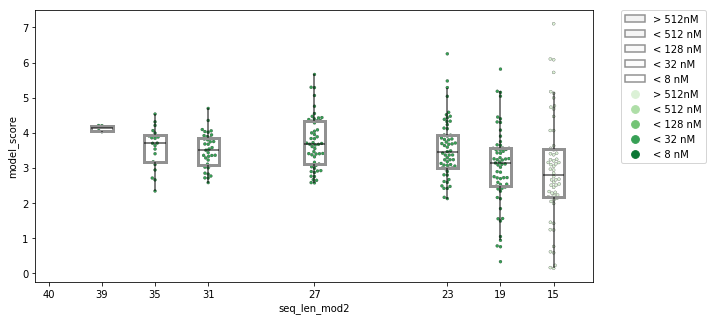

In [ ]:
# Figure 4A
plot_swarm_and_box_plots(trunc_validated_df_median, trunc_validated_df,
                         'SuperBin', 'G12')

    

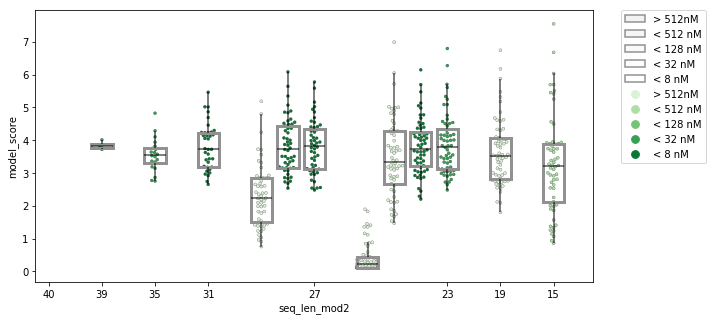

In [ ]:
# Figure 4A
plot_swarm_and_box_plots(trunc_validated_df_median, trunc_validated_df,
                         'SuperBin', 'G13')
